In [1]:
!pip install dice_ml
!pip install yprov4ml
!apt-get -qq install graphviz
!pip install graphviz

In [2]:
# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

import pandas as pd
import matplotlib
import networkx
import sklearn
import numpy as np
import prov
import tqdm
import yprov4ml
import graphviz
from IPython.display import SVG, display

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Start the provenance run
yprov4ml.start_run(
    prov_user_namespace="www.example.og",
    experiment_name="DiCE",
    provenance_save_dir="/save/path"
)

[codecarbon WARNING @ 15:57:59] Multiple instances of codecarbon are allowed to run at the same time.


## Preliminaries: Loading a dataset and a ML model trained over it
### Loading the `Adult` dataset

We use the "adult" income dataset from UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/adult). For demonstration purposes, we transform the data as described in **dice_ml.utils.helpers** module.

In [5]:
dataset = helpers.load_adult_income_dataset()

yprov4ml.log_dataset(dataset, "train_data")

/usr/local/lib/python3.12/dist-packages/dice_ml/utils/helpers.py:79: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adult_data = adult_data.replace({'income': {'<=50K': 0, '>50K': 1}})


This dataset has 8 features. The outcome is income which is binarized to 0 (low-income, <=50K) or 1 (high-income, >50K).

In [6]:
dataset.head()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0


In [7]:
# description of transformed features
adult_info = helpers.get_adult_data_info()
adult_info

yprov4ml.log_param("feature_age", adult_info['age'])
yprov4ml.log_param("feature_workclass", adult_info['workclass'])
yprov4ml.log_param("feature_education", adult_info['education'])
yprov4ml.log_param("feature_marital_status", adult_info['marital_status'])
yprov4ml.log_param("feature_occupation", adult_info['occupation'])
yprov4ml.log_param("feature_race", adult_info['race'])
yprov4ml.log_param("feature_gender", adult_info['gender'])
yprov4ml.log_param("feature_hours_per_week", adult_info['hours_per_week'])
yprov4ml.log_param("feature_income", adult_info['income'])

Split the dataset into train and test sets.

In [8]:
target = dataset["income"]
train_dataset, test_dataset, y_train, y_test = train_test_split(dataset,
                                                                target,
                                                                test_size=0.2,
                                                                random_state=0,
                                                                stratify=target)
x_train = train_dataset.drop('income', axis=1)
x_test = test_dataset.drop('income', axis=1)

x_train.to_csv('x_train.csv', index=False)
x_test.to_csv('x_test.csv', index=False)

yprov4ml.log_dataset(x_train, "x_train")
yprov4ml.log_dataset(x_test, "x_test")

Given the train dataset, we construct a data object for DiCE. Since continuous and discrete features have different ways of perturbation, we need to specify the names of the continuous features. DiCE also requires the name of the output variable that the ML model will predict.

In [9]:
# Step 1: dice_ml.Data
d = dice_ml.Data(dataframe=train_dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')

### Loading the ML model

DiCE supports sklearn, tensorflow and pytorch models.

The variable *backend* below indicates the implementation type of DiCE we want to use. Four backends are supported: sklearn, TensorFlow 1.x with backend='TF1', Tensorflow 2.x with backend='TF2', and PyTorch with backend='PYT'.

Below we show use a trained classification model using sklearn.

In [10]:
numerical = ["age", "hours_per_week"]
categorical = x_train.columns.difference(numerical)

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier())])
model = clf.fit(x_train, y_train)

import joblib
joblib.dump(model, "model.pkl")


yprov4ml.log_artifact("Random Forest Classifier", "/content/drive/model.pkl")

<ProvEntity: Random Forest Classifier>

## Generating counterfactual examples using DiCE

We now initialize the DiCE explainer, which needs a dataset and a model. DiCE provides local explanation for the model *m* and requires an query input whose outcome needs to be explained.

In [11]:
# Using sklearn backend
m = dice_ml.Model(model=model, backend="sklearn")
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m, method="random")

The `method` parameter specifies the explanation method. DiCE supports three methods for sklearn models: random sampling, genetic algorithm search, and kd-tree based generation.  

The next code snippet shows how to generate and visualize counterfactuals. The first argument of the `generate_counterfactuals` method is the _query instances_ on which counterfactuals are desired. This can be a dataframe with one or more rows.

Below we provide a sample input whose outcome is 0 (low-income) as per the ML model object *m*. Given the query input, we can now generate counterfactual explanations to show perturbed inputs from the original input where the ML model outputs class 1 (high-income). The last column shows the output of the classifier: `income-output` >=0.5 is class 1 and `income-output`<0.5 is class 0.

In [12]:
e1 = exp.generate_counterfactuals(x_test[0:1], total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,-,Self-Employed,-,-,Professional,-,-,-,1
1,-,-,Prof-school,-,-,-,Male,-,1


The `show_only_changes` parameter highlights the changes from the query instance. If you would like to see the full feature values for the counterfactuals, set it to False.

In [13]:
e1.visualize_as_dataframe(show_only_changes=False)

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Self-Employed,HS-grad,Married,Professional,White,Female,38,1
1,29,Private,Prof-school,Married,Blue-Collar,White,Male,38,1


That's it! You can try generating counterfactual explanations for other examples using the same code.
It is also possible to restrict the features to vary while generating the counterfactuals, and to specify permitted range of features within which the counterfactual should be generated.

In [14]:
# Changing only age and education
e2 = exp.generate_counterfactuals(x_test[0:1],
                                  total_CFs=2,
                                  desired_class="opposite",
                                  features_to_vary=["education", "occupation"]
                                  )
e2.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,-,-,Masters,-,Sales,-,-,-,1
1,-,-,Masters,-,Professional,-,-,-,1


In [15]:
# Restricting age to be between [20,30] and Education to be either {'Doctorate', 'Prof-school'}.
e3 = exp.generate_counterfactuals(x_test[0:1],
                                  total_CFs=2,
                                  desired_class="opposite",
                                  permitted_range={'age': [20, 30], 'education': ['Doctorate', 'Prof-school']})
e3.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,-,Government,-,-,Professional,-,-,-,1
1,-,-,Doctorate,-,White-Collar,-,-,-,1


## Generating feature attributions (local and global) using DiCE

DiCE can generate feature importance scores using a summary of the counterfactuals generated. Intuitively, a feature that is changed more often when generating proximal counterfactuals for an input is locally important for causing the model's prediction at the input. Formally, counterfactuals operationalize the __necessity__ criterion for a model explanation: _is the feature value necessary for the given model output?_

For more details, refer to the paper, [Towards Unifying Feature Attribution and Counterfactual Explanations: Different Means to the Same End](https://arxiv.org/abs/2011.04917).

### Local feature importance scores

These scores are computed for a given query instance (input point) by summarizing a set of counterfactual examples around the point.

In [16]:
query_instance = x_test[0:1]
imp = exp.local_feature_importance(query_instance, total_CFs=10)
print(imp.local_importance)

100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

[{'education': 0.7, 'occupation': 0.6, 'workclass': 0.3, 'gender': 0.3, 'marital_status': 0.1, 'race': 0.0, 'age': 0.0, 'hours_per_week': 0.0}]


The `total_CFs` parameter denotes the number of counterfactuals that are used to create the local importance. More the better.

### Global feature importance scores

A global importance score per feature can be estimated by aggregating the scores over individual inputs. The more the inputs, the better the estimate for global importance of a feature.

In [17]:
query_instances = x_test[0:20]
imp = exp.global_feature_importance(query_instances)
print(imp.summary_importance)

100%|██████████| 20/20 [00:09<00:00,  2.07it/s]

{'education': 0.655, 'occupation': 0.29, 'hours_per_week': 0.27, 'marital_status': 0.255, 'age': 0.195, 'workclass': 0.185, 'race': 0.105, 'gender': 0.085}


## Working with deep learning models (TensorFlow and PyTorch)

We now show examples of gradient-based methods with Tensorflow and Pytorch models. Since the gradient-based methods _optimize_ the loss rather than simply sampling some points, they can be slower to generate counterfactuals. The loss is defined by three component: **validity** (does the CF have the desired model output), **proximity** (distance of CF from original point should be low), and **diversity** (multiple CFs should change different features). The DiCE loss formulation is described in the paper, [Explaining Machine Learning Classifiers through Diverse Counterfactual Explanations](https://arxiv.org/abs/1905.07697).

Below, we use a pre-trained ML model which produces high accuracy comparable to other baselines. For convenience, we include the sample trained model with the DiCE package.

### Explaining a Tensorflow model

In [18]:
backend = 'TF2'  # needs tensorflow installed
ML_modelpath = helpers.get_adult_income_modelpath(backend=backend)
# Step 2: dice_ml.Model
m = dice_ml.Model(model_path=ML_modelpath, backend=backend, func="ohe-min-max")

We want to note that the time required to find counterfactuals with Tensorflow 2.x's eager style of execution is significantly greater than that with TensorFlow 1.x's graph execution.

Based on the data object *d* and the model object *m*, we can now instantiate the DiCE class for generating explanations.

In [19]:
# Step 3: initiate DiCE
exp = dice_ml.Dice(d, m, method="gradient")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Below we provide query instances from `x_test`.

In [20]:
# generate counterfactuals
dice_exp = exp.generate_counterfactuals(x_test[1:2], total_CFs=4, desired_class="opposite")
# visualize the result, highlight only the changes
dice_exp.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [02:17<00:00, 137.76s/it]

Diverse Counterfactuals found! total time taken: 02 min 17 sec
Query instance (original outcome : 0.6710000038146973)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,50,Other/Unknown,Some-college,Married,Other/Unknown,White,Male,40,0.671



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,23,-,-,-,-,-,-,13,0
1,17,-,-,-,-,Other,-,-,0
2,-,-,School,Single,-,-,-,-,0
3,62,-,-,Divorced,Blue-Collar,-,-,-,0


The counterfactuals generated above are slightly different from those shown in [our paper](https://arxiv.org/pdf/1905.07697.pdf), where the loss convergence condition was made more conservative for rigorous experimentation. To replicate the results in the paper, add an argument *loss_converge_maxiter=2* (the default value is 1) in the *exp.generate_counterfactuals()* method above. For more info, see *generate_counterfactuals()* method in [dice_ml.dice_interfaces.dice_tensorflow.py](https://github.com/interpretml/DiCE/blob/master/dice_ml/dice_interfaces/dice_tensorflow1.py).

### Explaining a Pytorch model

Just change the backend variable to 'PYT' to use DiCE with PyTorch. Below, we use a pre-trained ML model in PyTorch which produces high accuracy comparable to other baselines. For convenience, we include the sample trained model with the DiCE package. Additionally, we need to provide a data transformer function that converts input dataframe into one-hot encoded/numeric format.

In [21]:
backend = 'PYT'  # needs pytorch installed
ML_modelpath = helpers.get_adult_income_modelpath(backend=backend)
m = dice_ml.Model(model_path=ML_modelpath, backend=backend,  func="ohe-min-max")

Instantiate the DiCE class with the new PyTorch model object *m*.

In [22]:
exp = dice_ml.Dice(d, m, method="gradient")

In [23]:
# generate counterfactuals
dice_exp = exp.generate_counterfactuals(x_test[1:3], total_CFs=4, desired_class="opposite")
# highlight only the changes
dice_exp.visualize_as_dataframe(show_only_changes=True)

 50%|█████     | 1/2 [00:10<00:10, 10.65s/it]

Diverse Counterfactuals found! total time taken: 00 min 10 sec


100%|██████████| 2/2 [00:22<00:00, 11.31s/it]

Diverse Counterfactuals found! total time taken: 00 min 11 sec
Query instance (original outcome : 0.6179999709129333)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,50,Other/Unknown,Some-college,Married,Other/Unknown,White,Male,40,0.618



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,38,-,-,-,-,-,-,26,0
1,-,-,-,-,Blue-Collar,-,Female,-,0
2,-,Government,School,Single,-,-,-,-,0
3,70,-,-,Divorced,-,Other,-,-,0


Query instance (original outcome : 0.9679999947547913)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,50,Private,Bachelors,Married,Professional,White,Male,40,0.968



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,18,-,-,-,-,-,-,35,0
1,-,-,Some-college,Separated,Service,-,-,-,0
2,69,-,-,Single,-,-,-,-,0
3,-,Other/Unknown,School,-,-,-,Female,-,0


We can also use method-agnostic explainers like "random" or "genetic".

In [24]:
m = dice_ml.Model(model_path=ML_modelpath, backend=backend, func="ohe-min-max")
exp = dice_ml.Dice(d, m, method="random")

In [25]:
# generate counterfactuals
dice_exp = exp.generate_counterfactuals(x_test[1:3], total_CFs=4, desired_class="opposite")
# highlight only the changes
dice_exp.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,50,Other/Unknown,Some-college,Married,Other/Unknown,White,Male,40,1



Diverse Counterfactual set (new outcome: 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,-,-,HS-grad,-,Sales,-,-,-,0
1,-,-,-,Separated,-,-,-,28,0
2,73,-,-,-,-,-,Female,-,0
3,-,-,School,-,Professional,-,-,-,0


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,50,Private,Bachelors,Married,Professional,White,Male,40,1



Diverse Counterfactual set (new outcome: 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,-,-,School,-,-,Other,-,-,0
1,-,Self-Employed,-,Separated,-,-,-,-,0
2,-,-,-,Widowed,Sales,-,-,-,0
3,-,Other/Unknown,-,Single,-,-,-,-,0


In [26]:
yprov4ml.end_run(create_graph=True, create_svg=True)

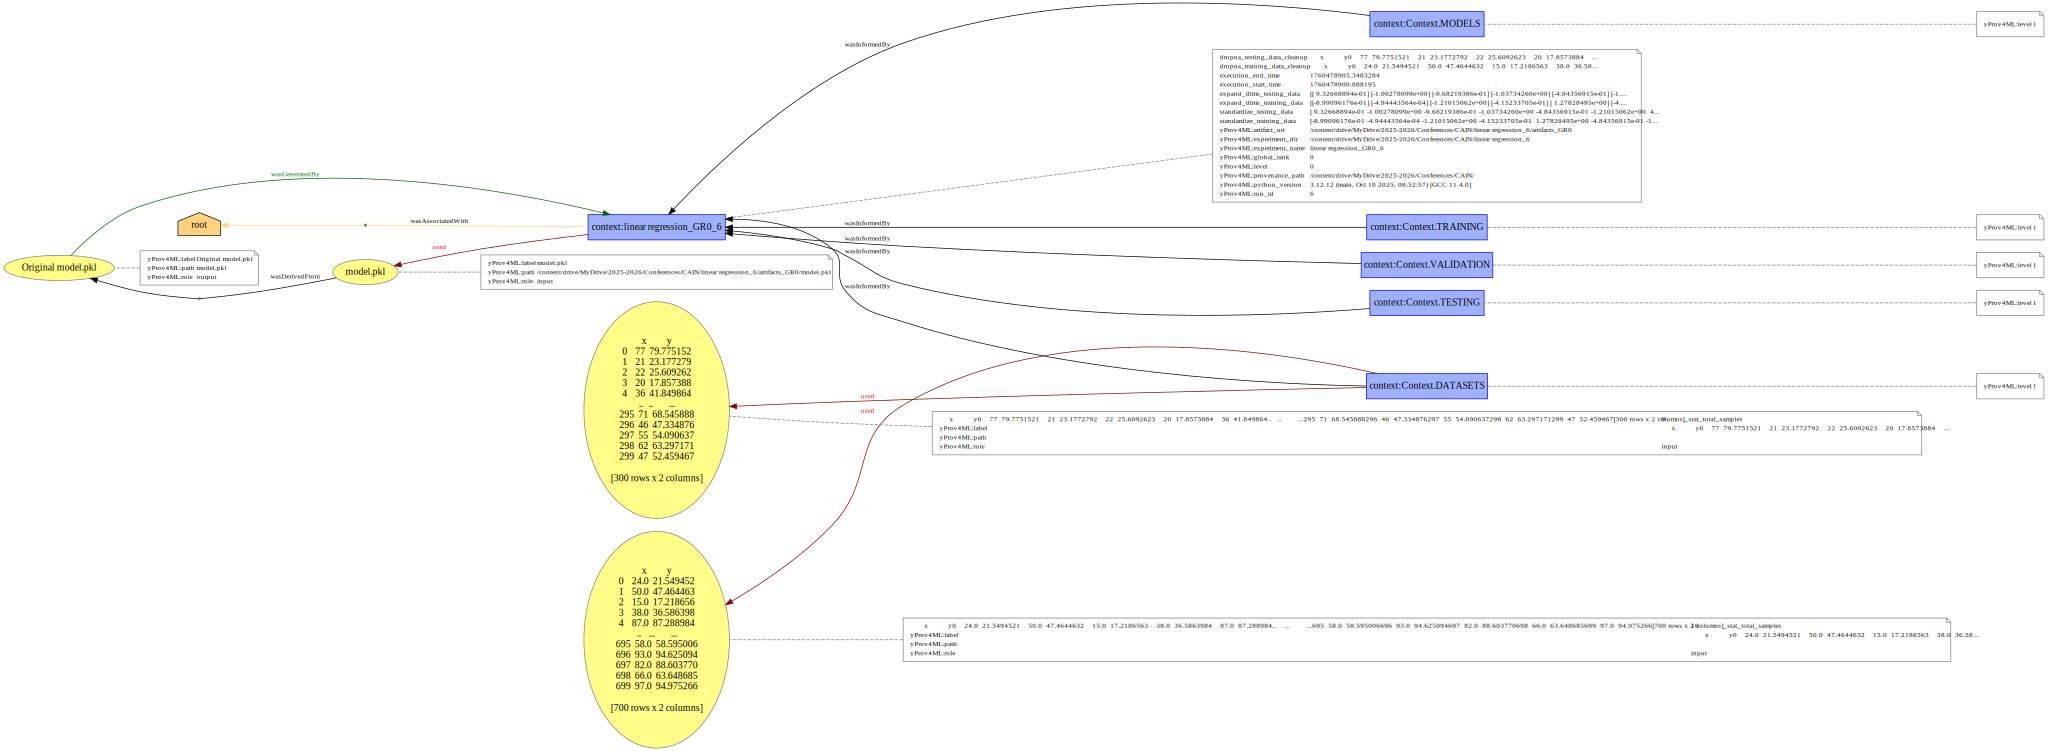

'prov_graph.png'

In [ ]:
filename = "/save/path/prov_DiCE_GR0.dot"

# Read the content of the .dot file
with open(filename, 'r') as f:
    dot_content = f.read()

# Create a Graphviz object from the .dot content
graph = graphviz.Source(dot_content)

# Render the graph to SVG and display it
display(SVG(graph.pipe(format='svg')))

graph.render(filename='prov_graph', format='png', cleanup=True)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_counterfactual_ball(
    X,
    y,
    quantile=0.9,
    imperfect=True,
    fig_size=(8,8),
    save_path=None,
    xlabel="",
    ylabel="",
    zlabel=""
):
    """
    Plot 3D scatter with an 'imperfect sphere' boundary.
    Points with y=1 are considered inside; y=0 are outside.
    """
    X = np.asarray(X)
    y = np.asarray(y).astype(int)
    assert X.ndim == 2 and X.shape[1] == 3, "X must be (n,3)"
    assert y.shape[0] == X.shape[0], "X and y must have same length"

    # Center + radius from positives
    pos = X[y == 1] if (y == 1).any() else X
    center = pos.mean(axis=0)
    dists = np.linalg.norm(pos - center, axis=1)
    radius = np.quantile(dists, quantile)

    # Wireframe "imperfect sphere"
    u = np.linspace(0, 2*np.pi, 80)
    v = np.linspace(0, np.pi, 60)
    U, V = np.meshgrid(u, v, indexing="ij")
    ax_scale = np.array([1.15, 0.95, 1.05]) if imperfect else np.array([1,1,1])
    ripple = 0.05*np.sin(3*U)*np.sin(2*V) if imperfect else 0
    Xs = center[0] + (radius*ax_scale[0])*np.cos(U)*np.sin(V) + ripple
    Ys = center[1] + (radius*ax_scale[1])*np.sin(U)*np.sin(V) + ripple
    Zs = center[2] + (radius*ax_scale[2])*np.cos(V) + 0.5*ripple

    inside_mask = np.linalg.norm((X-center)/ax_scale, axis=1) <= radius

    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_wireframe(Xs, Ys, Zs, alpha=0.35)
    ax.scatter(X[inside_mask,0], X[inside_mask,1], X[inside_mask,2], marker="o", s=12, alpha=0.8)
    ax.scatter(X[~inside_mask,0], X[~inside_mask,1], X[~inside_mask,2], marker="x", s=12, alpha=0.8)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_zlabel(zlabel)
    ax.set_box_aspect([1,1,1])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    return {"center": center, "radius": float(radius)}

In [29]:
import pandas as pd
import numpy as np

# --- Choose which columns are features ---
# If you already know your model's feature columns, set them here:
feature_cols = [c for c in x_test.columns]  # or a specific list

# Which label do you want to treat as "inside the sphere"?
# Commonly 1 = desired/positive, 0 = other. Adjust as needed.
positive_class = 1

all_rows = []

for block in dice_exp.cf_examples_list:
    # factual
    f = block.test_instance_df.copy()
    f["is_cf"] = 0

    # counterfactuals (name may vary by DiCE version; often 'final_cfs_df')
    cfs = getattr(block, "final_cfs_df", None)
    if cfs is None:
        # Some versions use 'final_cfs_df_sparse' or have a helper;
        # fall back to visualize_as_dataframe if needed
        cfs = block.visualize_as_dataframe(show_only_changes=False)
    cfs = cfs.copy()
    cfs["is_cf"] = 1

    # combine
    part = pd.concat([f, cfs], ignore_index=True)

    # If DiCE already provides a prediction column, use it:
    # Common column names: 'predicted_outcome', 'outcome', 'prediction'
    pred_col = None
    for cand in ["predicted_outcome", "outcome", "prediction", "y"]:
        if cand in part.columns:
            pred_col = cand
            break

    if pred_col is None:
        # If not present, compute using your trained model:
        # (replace 'model' with your classifier/regressor; binarize if needed)
        preds = model.predict(part[feature_cols])
        part["predicted_outcome"] = preds
        pred_col = "predicted_outcome"

    # binarize to 0/1 (in case predictions are strings/labels)
    # Example: map {"no":0,"yes":1} or similar
    if part[pred_col].dtype.kind not in "bi":
        # try to coerce to 0/1 by equality check vs positive_class label
        # If your labels are strings, set positive_class to that string.
        y_bin = (part[pred_col] == positive_class).astype(int)
    else:
        y_bin = (part[pred_col] == positive_class).astype(int)

    part["_y_bin"] = y_bin
    all_rows.append(part)

df_all = pd.concat(all_rows, ignore_index=True)


In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd

# Use numerical features and one categorical feature for PCA
numerical_features = ['age', 'hours_per_week']
categorical_features = ['education'] # Choosing 'education' as an example categorical feature

# Create a preprocessor to handle both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Apply preprocessing and then PCA to reduce to 3 components
X_processed = preprocessor.fit_transform(df_all[numerical_features + categorical_features])
X3D = PCA(n_components=3, random_state=0).fit_transform(X_processed)

# Labels: 1 = inside sphere, 0 = outside
y_all = df_all["_y_bin"].to_numpy()

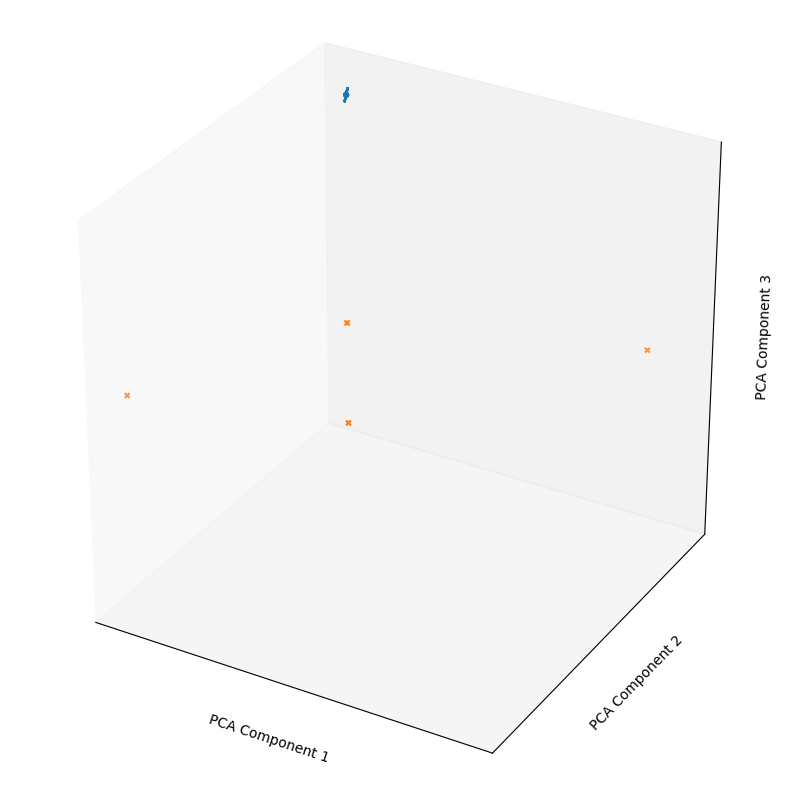

{'center': array([-2.2167426 ,  1.40518901,  0.57455309]), 'radius': 0.0}

In [31]:
plot_counterfactual_ball(X3D, y_all, quantile=0.9, imperfect=True,
                         save_path="counterfactual_ball.png",
                         xlabel="PCA Component 1", ylabel="PCA Component 2", zlabel="PCA Component 3")

In [32]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Select the 'education' column
education_col = df_all[['education']]

# Initialize the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the 'education' column
education_encoded = encoder.fit_transform(education_col)

# Convert the encoded array back to a DataFrame with appropriate column names
education_encoded_df = pd.DataFrame(education_encoded, columns=encoder.get_feature_names_out(['education']))

# Display the first few rows of the original and encoded dataframes to show the transformation
print("Original 'education' column:")
display(education_col.head())

print("\nOne-hot encoded 'education' column:")
display(education_encoded_df.head())

Original 'education' column:


,education
0,Some-college
1,HS-grad
2,Some-college
3,Some-college
4,School



One-hot encoded 'education' column:


,education_Bachelors,education_HS-grad,education_School,education_Some-college
0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0


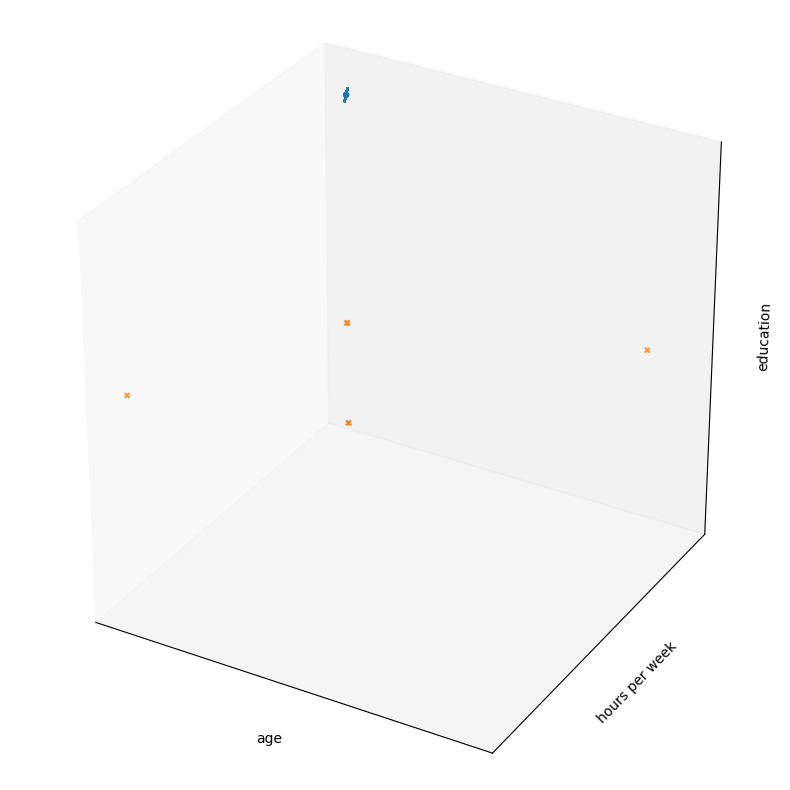

{'center': array([-2.2167426 ,  1.40518901,  0.57455309]), 'radius': 0.0}

In [33]:
# Use the 3 PCA components generated in the previous cell for plotting
plot_counterfactual_ball(X3D, y_all, quantile=0.9, imperfect=True,
                         xlabel="age", ylabel="hours per week", zlabel="education")